In [1]:
!nvidia-smi

Tue May  7 13:40:46 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:04:00.0 Off |                  N/A |
| 30%   31C    P8    23W / 250W |      1MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from src.segmentation.framework_handlers import ultralytics_handler
ultralytics_handler.validate_version_and_gpu()

Ultralytics YOLOv8.2.9 🚀 Python-3.10.0 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11019MiB)
Setup complete ✅ (12 CPUs, 61.5 GB RAM, 48.7/207.2 GB disk)


### Prepare Dataset
In this section, the dataset along with YOLO annotations is processed to conform to the input structure required by YOLO. The YOLO format necessitates organizing the dataset into two main directories, `images` and `labels`. Each of these directories is further divided into two subdirectories, `train` and `val`, for training and validation datasets respectively. This structure facilitates YOLO's training and validation processes.
WE can process the data by two options:
- Single SegmentsAI dataset
- Two SegmentsAI datasets, one for train and the other for test

In [1]:
from src.datasets_and_annotations import annotation_handler

Option 1: prepare data using a single dataset by splitting to train and test

In [4]:
# prepare data from a single dataset to fine tune yolo v5
train_annotations_folder_name = "etaylor_cannabis_patches_test"
train_dataset_version = "v0.1"
saving_yaml_path = "/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO"
yaml_file_path = annotation_handler.convert_coco_to_yolo_format_from_single_dataset(train_annotations_folder_name, train_dataset_version, saving_yaml_path, train_percentage=0.8)

Annotations /sise/home/etaylor/code_projects/thesis/segments/etaylor_stigmas_dataset/annotations/export_coco-instance_etaylor_stigmas_dataset_v0.2.json:   0%|          | 0/112 [00:00<?, ?it/s]


ValueError: cannot reshape array of size 1 into shape (2)

Option 2: prepare dataset by using two different segments datasets, one for train and second for eval

In [9]:
# prepare data from a train and test datasets to fine tune yolo v5
train_annotations_folder_name = "etaylor_cannabis_patches_train_26-04-2024_15-44-44"
train_dataset_version = "v0.1"
test_annotations_folder_name = "etaylor_cannabis_patches_test_26-04-2024_15-44-44"
test_dataset_version = "v0.1"
saving_yaml_path = "/home/etaylor/code_projects/thesis/src/segmentation/notebooks/ultralytics/yaml_files"
yaml_file_path = annotation_handler.convert_coco_to_yolo_format_from_train_test_datasets(train_annotations_folder_name, 
                                                                                        train_dataset_version, 
                                                                                        test_annotations_folder_name,
                                                                                        test_dataset_version,
                                                                                        saving_yaml_path, 
                                                                                        )

Annotations /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/annotations/export_coco-instance_etaylor_cannabis_patches_train_26-04-2024_15-44-44_v0.1.json: 100%|██████████| 369/369 [00:00<00:00, 389.55it/s]

COCO data converted successfully.
Results saved to /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/annotations/yolo



Annotations /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/annotations/export_coco-instance_etaylor_cannabis_patches_test_26-04-2024_15-44-44_v0.1.json: 100%|██████████| 106/106 [00:00<00:00, 418.79it/s]

COCO data converted successfully.
Results saved to /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/annotations/yolo


YAML configuration file saved to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/ultralytics/yaml_files/yolo_dataset_config.yaml


### Ultralytics Settings

In here we can modify the settings of the yolo runs. 

In [3]:
from ultralytics import settings
import config


runs_dir = "/home/etaylor/code_projects/thesis/src/segmentation/notebooks/ultralytics/runs"
# Update a setting
settings.update({'runs_dir': config.ULTRALYTICS_RUNS_DIR, 'weights_dir': config.ULTRALYTICS_WEIGHTS_DIR, 'datasets_dir': config.ULTRALYTICS_DATASETS_DIR})

# View all settings
print(settings)

{'settings_version': '0.0.4', 'datasets_dir': '/home/etaylor/code_projects/thesis/src/segmentation/notebooks/ultralytics/datasets', 'weights_dir': '/home/etaylor/code_projects/thesis/src/segmentation/notebooks/ultralytics/weights', 'runs_dir': '/home/etaylor/code_projects/thesis/src/segmentation/notebooks/ultralytics/runs', 'uuid': '0def00e56c3a400afc7ba4172404e1311f32262b0c5348e767a82883f2e1b76d', 'sync': True, 'api_key': '', 'openai_api_key': '', 'clearml': True, 'comet': True, 'dvc': True, 'hub': True, 'mlflow': True, 'neptune': True, 'raytune': True, 'tensorboard': True, 'wandb': True}


In [4]:
# in case dataset already converted from coco to yolo format use manual path
yaml_file_path = "/home/etaylor/code_projects/thesis/src/segmentation/notebooks/ultralytics/yaml_files/yolo_dataset_config.yaml"

In [11]:
import torch
torch.cuda.empty_cache()

### Find best Hyper params with Tune

In the provided code snippet we are using `model.tune` for hyperparameter tuning.

In [7]:
import os

# currently available models for train and hparams fine tune
ultralytics_checkpoint_paths = "/home/etaylor/code_projects/thesis/checkpoints/ultralytics"

available_models_checkpoints = {
    "yolov5": "yolov5xu.pt",
    "yolov8": "yolov8x.pt",
    "yolov9": "yolov9c.pt",
    "rt_detr": "rtdetr-x.pt",
}
model_checkpoint_path = os.path.join(ultralytics_checkpoint_paths, available_models_checkpoints["yolov5"])

Here we can select between using the yolo models or the RT_DETR models

In [8]:
from ultralytics import YOLO

model = YOLO(model_checkpoint_path)

If using the RT DETR models use the code below

In [ ]:
# from ultralytics import RTDETR

# model_checkpoint_path = os.path.join(ultralytics_checkpoint_paths, available_models_checkpoints["rt_detr"])
# model = RTDETR(model_checkpoint_path)

In [13]:
# Start tuning hyperparameters for YOLOv8n training on the COCO8 dataset
result_grid = model.tune(data=yaml_file_path, batch=8, imgsz=512, device=0)

Tuner: Initialized Tuner instance with 'tune_dir=/home/etaylor/code_projects/thesis/src/segmentation/notebooks/ultralytics/runs/detect/tune15'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
New https://pypi.org/project/ultralytics/8.2.10 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.9 🚀 Python-3.10.0 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11019MiB)
engine/trainer: task=detect, mode=train, model=/home/etaylor/code_projects/thesis/checkpoints/ultralytics/yolov5xu.pt, data=/home/etaylor/code_

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


YOLOv5x summary: 493 layers, 97202297 parameters, 97202281 gradients, 246.9 GFLOPs

Transferred 817/823 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir /home/etaylor/code_projects/thesis/src/segmentation/notebooks/ultralytics/runs/detect/train98', view at http://localhost:6006/
Freezing layer 'model.24.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/annotations/yolo_split/labels.cache... 369 images, 395 backgrounds, 0 corrupt: 100%|██████████| 764/764 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/home/etaylor/.conda/envs/yolov9/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/annotations/yolo_split/labels.cache... 106 images, 108 backgrounds, 0 corrupt: 100%|██████████| 214/214 [00:00<?, ?it/s]
/home/etaylor/.conda/envs/yolov9/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoade

Plotting labels to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/ultralytics/runs/detect/train98/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 135 weight(decay=0.0), 142 weight(decay=0.0005), 141 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/ultralytics/runs/detect/train98
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.64G      1.533      2.941      1.222        105        512:  33%|███▎      | 32/96 [00:10<00:16,  3.78it/s]

KeyboardInterrupt: 

### Basic Trial-Level Analysis
Access individual trial hyperparameter configurations and the last reported metrics.



In [14]:
for i, result in enumerate(result_grid):
    print(f"Trial #{i}: Configuration: {result.config}\n Last Reported Metrics: {result.metrics}")

Trial #0: Configuration: {'lr0': 0.006810995589332796, 'lrf': 0.7029492659280141, 'momentum': 0.8459019634992753, 'weight_decay': 0.0009980101416019688, 'warmup_epochs': 4.251689510697102, 'warmup_momentum': 0.3300985934724798, 'box': 0.08398955284673744, 'cls': 3.214935988938527, 'hsv_h': 0.07466011874214247, 'hsv_s': 0.040220002159168745, 'hsv_v': 0.1414138247777253, 'degrees': 18.265160326975455, 'translate': 0.5737970115368398, 'scale': 0.5466930081480071, 'shear': 9.20721420287857, 'perspective': 0.00023956740154620204, 'flipud': 0.2173652574716607, 'fliplr': 0.7035965663278841, 'mosaic': 0.1374212008334823, 'mixup': 0.5263739413077916, 'copy_paste': 0.0446092205458547, 'data': '/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO8/yaml_files/etaylor_cannabis_patches_test_v0.1_data.yaml'}
 Last Reported Metrics: {'metrics/precision(B)': 0.4721975956343692, 'metrics/recall(B)': 0.6340826977117624, 'metrics/mAP50(B)': 0.5967712368069547, 'metrics/mAP50-95(B)': 0.301946

#### Plotting the Entire History of Reported Metrics for a Trial


In [35]:
result_grid[3].metrics

{'metrics/precision(B)': 0.49755374826791243,
 'metrics/recall(B)': 0.6299057559595497,
 'metrics/mAP50(B)': 0.5993370615135911,
 'metrics/mAP50-95(B)': 0.30186850131554777,
 'fitness': 0.33161535733535213,
 'timestamp': 1712673767,
 'checkpoint_dir_name': None,
 'done': True,
 'training_iteration': 1,
 'trial_id': '10d95_00003',
 'date': '2024-04-09_17-42-47',
 'time_this_iter_s': 154.70991253852844,
 'time_total_s': 154.70991253852844,
 'pid': 7897,
 'hostname': 'ise-6000-02',
 'node_ip': '132.72.66.158',
 'config': {'lr0': 0.008333149044128504,
  'lrf': 0.3727541775077848,
  'momentum': 0.9110019927438571,
  'weight_decay': 0.0007443981649398233,
  'warmup_epochs': 3.650867819694423,
  'warmup_momentum': 0.5698553239518751,
  'box': 0.12404697878048802,
  'cls': 0.5494803457497113,
  'hsv_h': 0.08557148013741318,
  'hsv_s': 0.4993750536684533,
  'hsv_v': 0.46960259135168053,
  'degrees': 21.529612922792687,
  'translate': 0.01337652777472852,
  'scale': 0.7485879481945585,
  'shear'

In [24]:
result_grid[1]

Result(
  metrics={'metrics/precision(B)': 0.625806954842417, 'metrics/recall(B)': 0.6332662623110966, 'metrics/mAP50(B)': 0.6330401153557118, 'metrics/mAP50-95(B)': 0.3967065348752621, 'fitness': 0.4203398929233071},
  path='/sise/home/etaylor/runs/detect/tune/_tune_2024-04-11_19-48-48/_tune_5e6c9_00001_1_box=0.0777,cls=0.4344,copy_paste=0.2669,degrees=3.6203,fliplr=0.1037,flipud=0.6340,hsv_h=0.0780,hsv_s=0.3442,h_2024-04-11_19-48-48',
  filesystem='local',
  checkpoint=None
)

### Compare the results of each tuned model

In [7]:
import pandas as pd

# Assuming `result_grid` is your list of Result objects
data = {
    'Precision': [],
    'Recall': [],
    'mAP50': [],
    'mAP50-95': [],
    'Fitness': []
}

for result in result_grid:
    metrics = result.metrics
    # Using .get() with a default value of None (or you could choose a more appropriate default value)
    data['Precision'].append(metrics.get('metrics/precision(B)', None))
    data['Recall'].append(metrics.get('metrics/recall(B)', None))
    data['mAP50'].append(metrics.get('metrics/mAP50(B)', None))
    data['mAP50-95'].append(metrics.get('metrics/mAP50-95(B)', None))
    data['Fitness'].append(metrics.get('fitness', None))

df = pd.DataFrame(data)


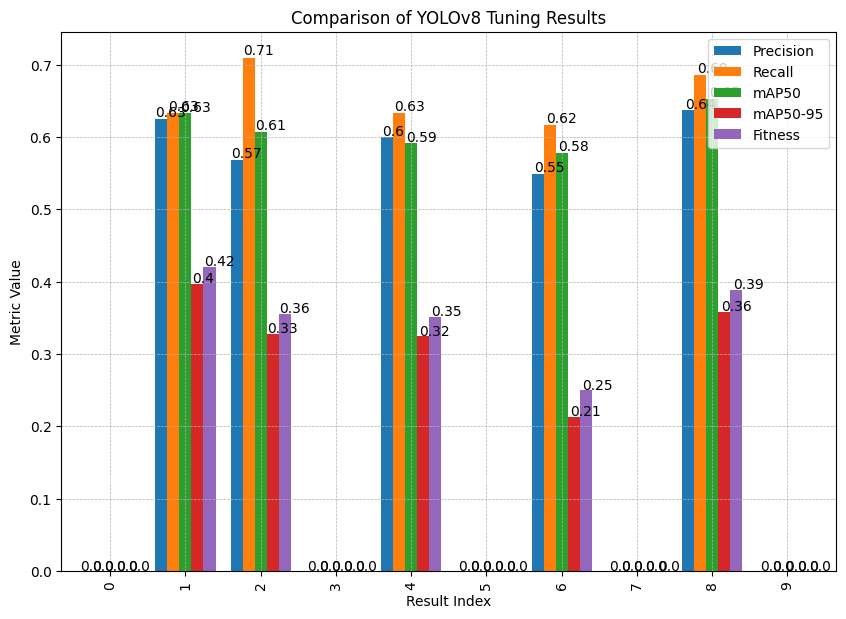

In [21]:
df_filled = df.fillna(0)  # Replace None with 0 for plotting
import matplotlib.pyplot as plt

# Plotting
ax = df_filled.plot(kind='bar', figsize=(10, 7), width=0.8)
ax.set_title('Comparison of YOLOv8 Tuning Results')
ax.set_xlabel('Result Index')
ax.set_ylabel('Metric Value')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(loc='upper right')

# Adding value labels on top of each bar
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()
